In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm
from random import seed,sample
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc,\
precision_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

## Import Data

In [2]:
df = pd.read_csv('Synthetic Data.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', 'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
display(df.head().round(4))
print('Missing Values =', df.isnull().values.sum())
print('Data Shape:', df.shape)

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Missing Values = 0
Data Shape: (6362620, 11)


## EDA (Exploratory Data Analysis)

In [3]:
print('The types of fraudulent transaction:', list(df.loc[df.isFraud == 1].type.drop_duplicates()))
print('The number of fraudulent TRANSFERs =', len(df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]))
print('The number of fraudulent CASH_OUTs =', len(df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]))

The types of fraudulent transaction: ['TRANSFER', 'CASH_OUT']
The number of fraudulent TRANSFERs = 4097
The number of fraudulent CASH_OUTs = 4116


### Correlation

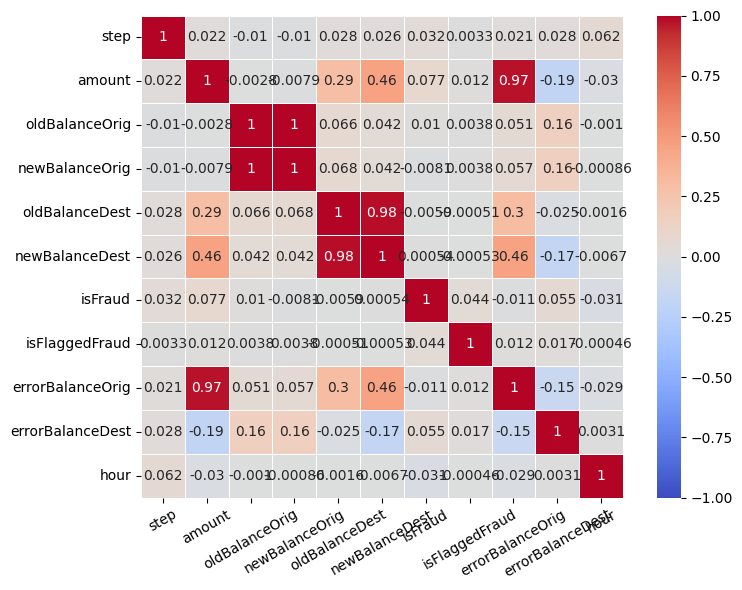

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, linewidths=0.5, cmap='coolwarm', square=True, vmin=-1, vmax=1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('Figure/Correlation Matrix.png', dpi=144, transparent=True)
plt.show()

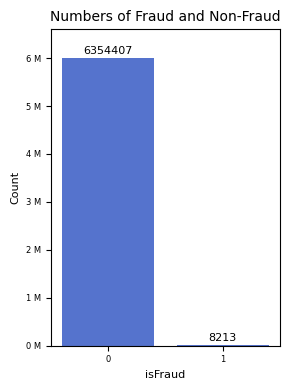

In [25]:
plt.figure(figsize=(3, 4))
ax = sns.countplot(x='isFraud', data=df, color='royalblue')
for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width() / 2, y=height+100000, s=int(height), ha='center', fontsize=8)
plt.tick_params(axis='both', labelsize=6)
plt.title('Numbers of Fraud and Non-Fraud', fontsize=10)
plt.ylim(0, (df['isFraud'].value_counts().max()) * 1.1)
yticks = np.linspace(0, df['isFraud'].value_counts().max(), 7)
ax.set_yticks(yticks)
ax.set_yticklabels([f'{int(label/1e6)} M' for label in ax.get_yticks()])
plt.xlabel('isFraud', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.tight_layout()
plt.savefig('Figure/Fraud vs Non-Fraud.png', dpi=144, transparent=True)
plt.show()

In [6]:
print('Number of transaction C-C:', len(df.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('C')]))
print('Number of transaction C-M:', len(df.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('M')]))
print('Number of transaction M-C:', len(df.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('C')]))
print('Number of transaction M-M:', len(df.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('M')]))

Number of transaction C-C: 4211125
Number of transaction C-M: 2151495
Number of transaction M-C: 0
Number of transaction M-M: 0


,count
type,
CASH_OUT,2237500
PAYMENT,2151495
CASH_IN,1399284
TRANSFER,532909
DEBIT,41432


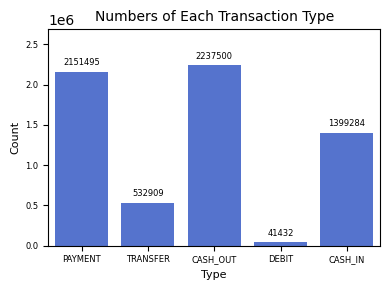

In [26]:
display(pd.DataFrame(df.type.value_counts()))
fig = plt.figure(figsize=(4, 3))
ax = sns.countplot(data=df, x='type', color='royalblue')
for patch in ax.patches:
    ax.text(patch.get_x() + patch.get_width()/2, patch.get_height()+60000, int(patch.get_height()),
            ha='center', va='bottom', fontsize=6)
plt.title('Numbers of Each Transaction Type', fontsize=10)
plt.tick_params(axis='both', labelsize=6)
plt.xlabel('Type', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.ylim(0, (df['type'].value_counts().max()) * 1.2)
plt.tight_layout()
plt.savefig('Figure/Transaction Type.png', dpi=144, transparent=True)
plt.show()

type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64


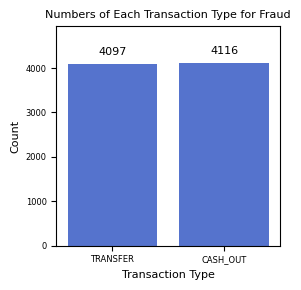

In [27]:
print(df[df.isFraud == 1].type.value_counts())
plt.figure(figsize=(3, 3))
ax = sns.countplot(data=df[df.isFraud == 1], x='type', color='royalblue')
for patch in ax.patches:
    ax.text(patch.get_x() + patch.get_width()/2, patch.get_height()+150, int(patch.get_height()),
            ha='center', va='bottom', fontsize=8)
plt.title('Numbers of Each Transaction Type for Fraud', fontsize=8)
plt.tick_params(axis='both', labelsize=6)
plt.xlabel('Transaction Type', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.ylim(0, (df[df.isFraud == 1].type.value_counts().max()) * 1.2)
plt.tight_layout()
plt.savefig('Figure/Transaction Type for Fraud.png', dpi=144, transparent=True)
plt.show()

,amount
type,
CASH_IN,168920.2420
CASH_OUT,176273.9643
DEBIT,5483.6653
PAYMENT,13057.6047
TRANSFER,910647.0096


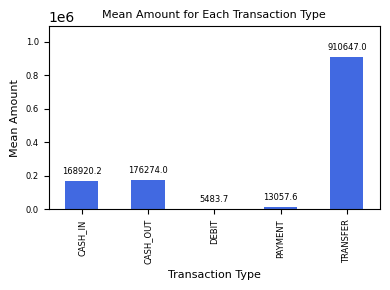

In [28]:
display(pd.DataFrame(df.groupby('type').amount.mean().apply(lambda x: '%.4f' % x)))
plt.figure(figsize=(4, 3))
ax = df.groupby('type').amount.mean().plot.bar(color='royalblue')
plt.title('Mean Amount for Each Transaction Type', fontsize=8)
plt.tick_params(axis='both', labelsize=6)
plt.xlabel('Transaction Type', fontsize=8)
plt.ylabel('Mean Amount', fontsize=8)
for patch in ax.patches:
    height = patch.get_height()
    ax.text(patch.get_x() + patch.get_width()/2, height+30000, f'{height:.1f}', ha='center', va='bottom', fontsize=6)
plt.ylim(0, (df.groupby('type').amount.mean().max()) * 1.2)
plt.tight_layout()
plt.savefig('Figure/Trandsaction Type Mean Amount.png', dpi=144, transparent=True)
plt.show()

isFraud
0     178197.0417
1    1467967.2991
Name: amount, dtype: object


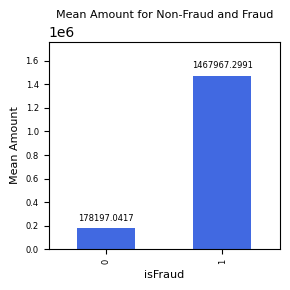

In [29]:
print(df.groupby('isFraud').amount.mean().apply(lambda x: '%.4f' % x))
plt.figure(figsize=(3, 3))
ax = df.groupby('isFraud').amount.mean().plot.bar(color='royalblue')
plt.title('Mean Amount for Non-Fraud and Fraud', fontsize=8)
plt.tick_params(axis='both', labelsize=6)
plt.xlabel('isFraud', fontsize=8)
plt.ylabel('Mean Amount', fontsize=8)
for patch in ax.patches:
    height = patch.get_height()
    ax.text(patch.get_x() + patch.get_width()/2, height+50000, f'{height:.4f}', ha='center', va='bottom', fontsize=6)
plt.ylim(0, (df.groupby('isFraud').amount.mean().max()) * 1.2)
plt.tight_layout()
plt.savefig('Figure/Fraud vs Non-Fraud Mean Amount.png', dpi=144, transparent=True)
plt.show()

In [11]:
x = sm.add_constant(df['isFraud'].astype(int))
model = sm.OLS(df.amount, x)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 amount   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                 3.764e+04
Date:                Fri, 11 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:30:40   Log-Likelihood:            -9.3703e+07
No. Observations:             6362620   AIC:                         1.874e+08
Df Residuals:                 6362618   BIC:                         1.874e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.782e+05    238.845    746.077      0.0

In [12]:
df['errorBalanceOrig'] = df['newBalanceOrig'] + df['amount'] - df['oldBalanceOrig']
df['errorBalanceDest'] = df['oldBalanceDest'] + df['amount'] - df['newBalanceDest']
print('Error balance for originator')
print(df.errorBalanceOrig.describe(), '\n')
print('Error balance for receiver')
print(df.errorBalanceDest.describe())

Error balance for originator
count    6.362620e+06
mean     2.010925e+05
std      6.066505e+05
min     -1.000000e-02
25%      2.954230e+03
50%      6.867726e+04
75%      2.496411e+05
max      9.244552e+07
Name: errorBalanceOrig, dtype: float64 

Error balance for receiver
count    6.362620e+06
mean     5.556717e+04
std      4.415288e+05
min     -7.588573e+07
25%      0.000000e+00
50%      3.500490e+03
75%      2.935305e+04
max      1.319123e+07
Name: errorBalanceDest, dtype: float64


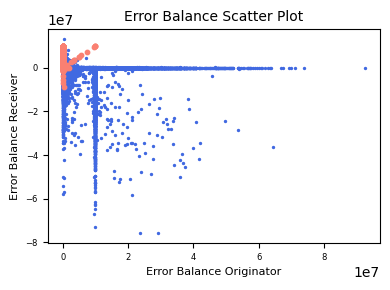

In [30]:
plt.figure(figsize=(4, 3))
mask_fraud = df['isFraud'] == 1
mask_valid = df['isFraud'] == 0
plt.scatter(df.loc[mask_valid, 'errorBalanceOrig'], df.loc[mask_valid, 'errorBalanceDest'], color='royalblue', s=2)
plt.scatter(df.loc[mask_fraud, 'errorBalanceOrig'], df.loc[mask_fraud, 'errorBalanceDest'], color='salmon', s=10)
plt.title('Error Balance Scatter Plot', fontsize=10)
plt.tick_params(axis='both', labelsize=6)
plt.xlabel('Error Balance Originator', fontsize=8)
plt.ylabel('Error Balance Receiver', fontsize=8)
plt.tight_layout()
plt.savefig('Figure/Error Balance Scatter Plot.png', dpi=144, transparent=True)
plt.show()

In [14]:
print(f'Total Flagged: {len(df[df.isFlaggedFraud == 1])}')
print(f'Numbers of Correctly Flagged: {len(df[df.isFlaggedFraud == 1][df[df.isFlaggedFraud == 1].isFraud == 1])}')
print(f'Numbers of Unflagged Fraud: {len(df[(df.isFlaggedFraud == 0) & (df.isFraud == 1)])}')

Total Flagged: 16
Numbers of Correctly Flagged: 16
Numbers of Unflagged Fraud: 8197


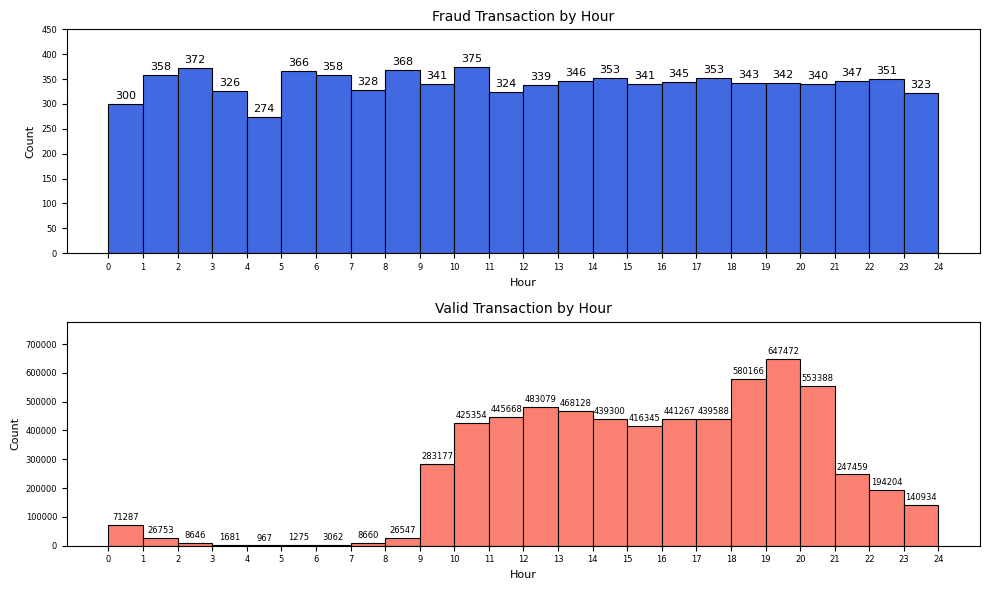

In [31]:
df['hour'] = df.step % 24

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.title('Fraud Transaction by Hour', fontsize=10)
plt.tick_params(axis='both', labelsize=6)
plt.xticks(list(range(25)))
plt.xlabel('Hour', fontsize=8)
plt.ylabel('Count', fontsize=8)
n, bins, patches = plt.hist(df[df.isFraud == 1]['hour'], bins=list(range(25)), color='royalblue', edgecolor='black', linewidth=0.8)
for i in range(len(patches)):
    plt.text(bins[i] + (bins[1]-bins[0])/2, n[i] + 6, str(int(n[i])), ha='center', va='bottom', fontsize=8)
plt.ylim(0, (df[df.isFraud == 1]['hour'].value_counts().max()) * 1.2)

plt.subplot(2, 1, 2)
plt.title('Valid Transaction by Hour', fontsize=10)
plt.tick_params(axis='both', labelsize=6)
plt.xticks(list(range(25)))
plt.xlabel('Hour', fontsize=8)
plt.ylabel('Count', fontsize=8)
n, bins, patches = plt.hist(df[df.isFraud == 0]['hour'], bins=list(range(25)), color='salmon', edgecolor='black', linewidth=0.8)
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width()/2, n[i] + 10000, str(int(n[i])), ha='center', va='bottom', fontsize=6)
plt.ylim(0, df[df.isFraud == 0]['hour'].value_counts().max() * 1.2)

plt.tight_layout()
plt.savefig('Figure/Transaction by Hour.png', dpi=144, transparent=True)
plt.show()

## Model Selection

In [16]:
df_model = df.copy()

df_model = df_model[(df_model["type"] == "CASH_OUT") | (df_model["type"] == "TRANSFER")]
df_model["errorBalanceOrig"] = df_model.newBalanceOrig + df_model.amount - df_model.oldBalanceOrig
df_model["errorBalanceDest"] = df_model.oldBalanceDest + df_model.amount - df_model.newBalanceDest
df_model = df_model.drop(columns=['nameOrig', 'nameDest'])
df_model = pd.get_dummies(df_model, columns=['type'], prefix = ['type'])

fraud = df_model[df_model["isFraud"] == 1]
valid = df_model[df_model["isFraud"] == 0]

In [17]:
X = df_model.drop("isFraud", axis=1)
y = df_model.isFraud
X_train, X_test, y_train, y_test = train_test_split(X,y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Model 1: Artificial Neural Networks

In [18]:
n_features = X.shape[1]
mlp_hidden = (n_features,) * 3
mlp_clf = MLPClassifier(hidden_layer_sizes=mlp_hidden, max_iter=1000)
mlp_clf.fit(X_train, y_train)

mlp_preds = mlp_clf.predict(X_test)
mlp_cm = confusion_matrix(y_test, mlp_preds)
mlp_cr = classification_report(y_test, mlp_preds)
mlp_fpr, mlp_tpr, mlp_thresh = roc_curve(y_test, mlp_preds)
mlp_auc = auc(mlp_fpr, mlp_tpr)

mlp_results = {"Classification Report": mlp_cr, "Area Under Curve": mlp_auc}

Classification Report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690585
           1       0.96      0.83      0.89      2018

    accuracy                           1.00    692603
   macro avg       0.98      0.92      0.95    692603
weighted avg       1.00      1.00      1.00    692603

Area Under Curve :
 0.9162015868349305


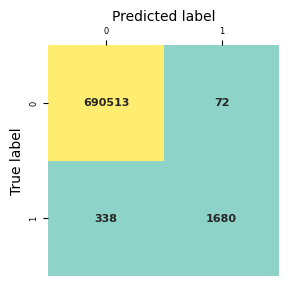

In [32]:
for measure in mlp_results:
    print(measure, ":\n", mlp_results[measure])

plt.figure(figsize=(3, 3))
ax = sns.heatmap(mlp_cm, annot=True, cbar=False, fmt="g", square=True, annot_kws={"fontsize": 8, 'fontweight': 'heavy'}, cmap="Set3")
ax.set_xlabel("Predicted label", fontsize=10)
ax.set_ylabel("True label", fontsize=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
plt.savefig('Figure/MLP Performance.png', dpi=144, transparent=True)
plt.show()

### Model 2: Random Forest

In [20]:
rf_params = {'n_estimators': 15, 'oob_score': False, 'class_weight': "balanced", 'n_jobs': -1}
rf_clf = RandomForestClassifier(**rf_params)
rf_clf.fit(X_train, y_train)

rf_preds = rf_clf.predict(X_test)
rf_cm = confusion_matrix(y_test, rf_preds)
rf_cr = classification_report(y_test, rf_preds)
rf_fpr, rf_tpr, rf_thresh = roc_curve(y_test, rf_preds)
rf_auc = auc(rf_fpr, rf_tpr)

rf_results = {"Classification Report": rf_cr, "Area Under Curve": rf_auc}

Classification Report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690585
           1       1.00      1.00      1.00      2018

    accuracy                           1.00    692603
   macro avg       1.00      1.00      1.00    692603
weighted avg       1.00      1.00      1.00    692603

Area Under Curve :
 0.9975215752824089


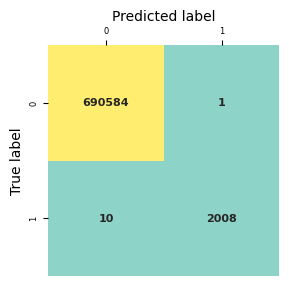

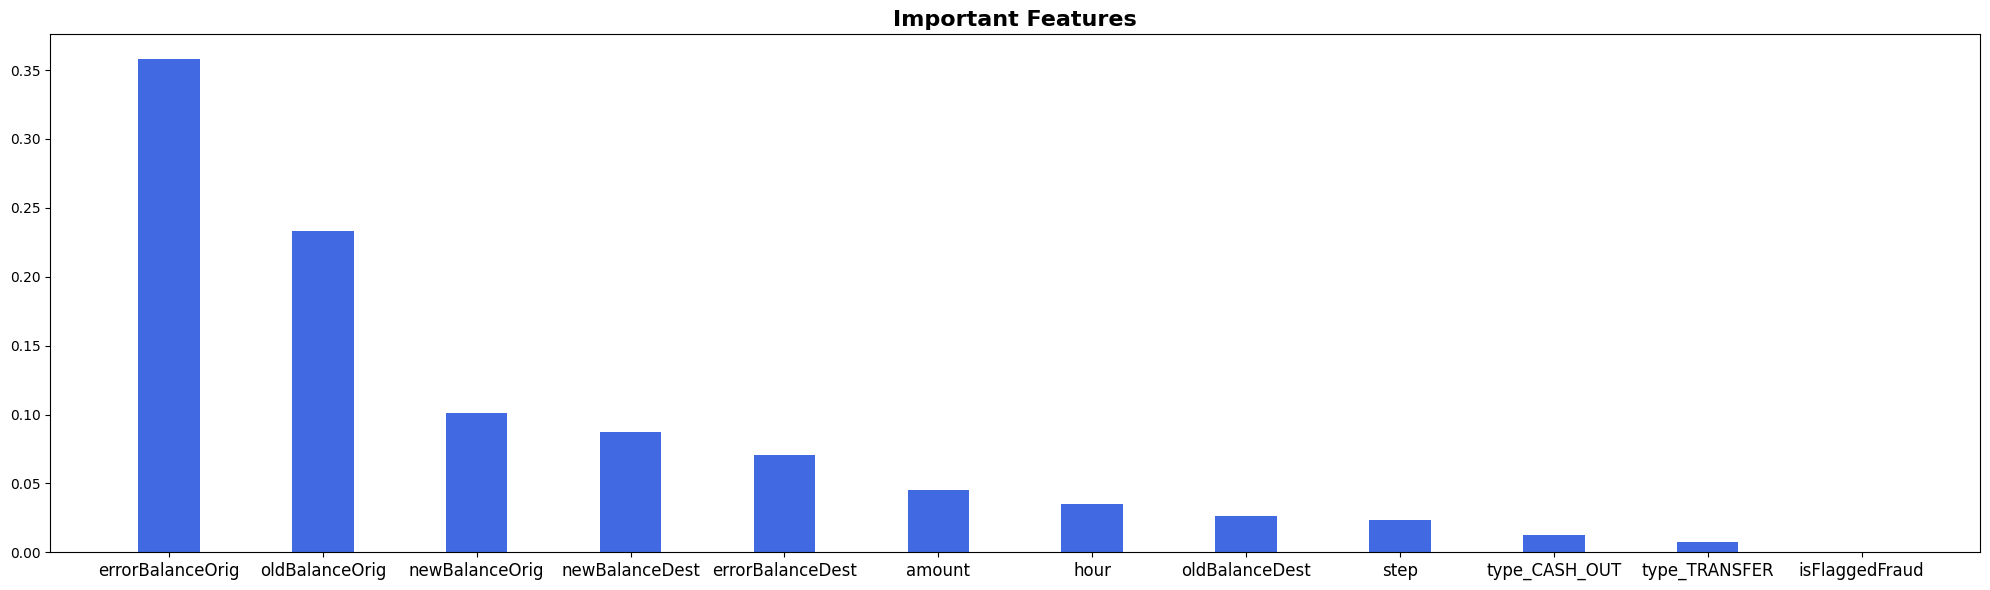

In [33]:
for measure in rf_results:
    print(measure, ":\n", rf_results[measure])

plt.figure(figsize=(3, 3))
ax = sns.heatmap(rf_cm, annot=True, cbar=False, fmt="g", square=True, annot_kws={"fontsize": 8, 'fontweight': 'heavy'}, cmap="Set3")
ax.set_xlabel("Predicted label", fontsize=10)
ax.set_ylabel("True label", fontsize=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
plt.savefig('Figure/RF Performance.png', dpi=144, transparent=True)
plt.show()

x = np.arange(X.shape[1])
importances = rf_clf.feature_importances_
sort_ind = np.argsort(importances)[::-1]
plt.figure(figsize=(20, 6))
plt.bar(x, importances[sort_ind], width=0.4, color='royalblue')
plt.xticks(x, tuple(X.columns.values[sort_ind]), fontsize=12)
plt.title("Important Features", fontsize=16, fontweight='heavy')
plt.tight_layout()
plt.savefig('Figure/RF Important Features.png', dpi=144, transparent=True)
plt.show()

### Model 3: XGB Trees

In [22]:
xgb_weight = (y == 0).sum() / (1.0 * (y == 1).sum())
xgb_params = {'max_depth': 3, 'scale_pos_weight': xgb_weight, 'n_jobs': -1, 'learning_rate': 0.1}
xgb_clf = XGBClassifier(**xgb_params)
xgb_clf.fit(X_train, y_train)

xgb_preds = xgb_clf.predict(X_test)
xgb_cm = confusion_matrix(y_test, xgb_preds)
xgb_cr = classification_report(y_test, xgb_preds)
xgb_fpr, xgb_tpr, xgb_thresh = roc_curve(y_test, xgb_preds)
xgb_auc = auc(xgb_fpr, xgb_tpr)

xgb_results = {"Classification Report": xgb_cr, "Area Under Curve": xgb_auc}

Classification Report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690585
           1       0.87      1.00      0.93      2018

    accuracy                           1.00    692603
   macro avg       0.93      1.00      0.96    692603
weighted avg       1.00      1.00      1.00    692603

Area Under Curve :
 0.9972956798459311


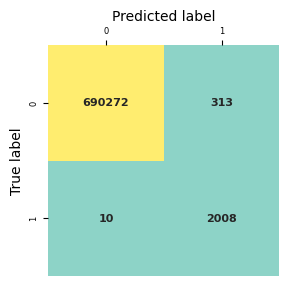

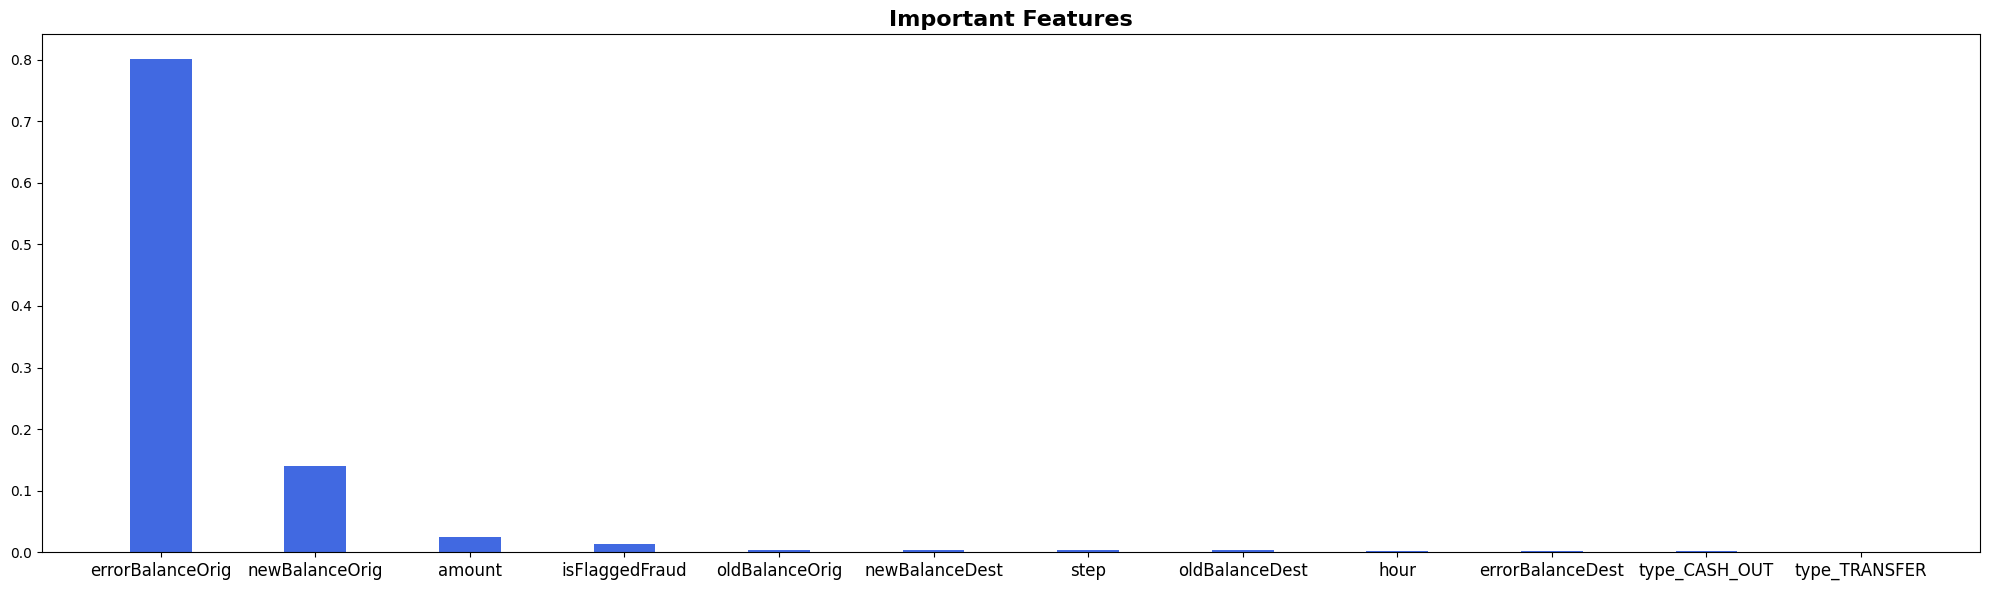

In [35]:
for measure in xgb_results:
    print(measure, ":\n", xgb_results[measure])

plt.figure(figsize=(3, 3))
ax = sns.heatmap(xgb_cm, annot=True, cbar=False, fmt="g", square=True, annot_kws={"fontsize": 8, 'fontweight': 'heavy'}, cmap="Set3")
ax.set_xlabel("Predicted label", fontsize=10)
ax.set_ylabel("True label", fontsize=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
plt.savefig('Figure/XGB Performance.png', dpi=144, transparent=True)
plt.show()

x = np.arange(X.shape[1])
importances = xgb_clf.feature_importances_
sort_ind = np.argsort(importances)[::-1]
plt.figure(figsize=(20, 6))
plt.bar(x, importances[sort_ind], width=0.4, color='royalblue')
plt.xticks(x, tuple(X.columns.values[sort_ind]), fontsize=12)
plt.title("Important Features", fontsize=16, fontweight='heavy')
plt.tight_layout()
plt.savefig('Figure/XGB Important Features.png', dpi=144, transparent=True)
plt.show()